In [1]:

%pprint

Pretty printing has been turned OFF



---
# Load needed libraries and functions

In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
if (osp.join(os.pardir, 'py') not in sys.path): sys.path.insert(1, osp.join(os.pardir, 'py'))

In [3]:

%matplotlib inline
from datetime import datetime
from neo4j.exceptions import ServiceUnavailable
import humanize
import matplotlib.pyplot as plt
import time
import winsound

bin_count = 12
duration = 1000  # milliseconds
freq = 880  # Hz
height_inches = 3.0
width_inches = 18.0

In [4]:

t0 = time.time()

# Get the Neo4j driver
from storage import Storage
s = Storage()

from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities(s=s)
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

# Get the neo4j object
from cypher_utils import CypherUtilities
cu = CypherUtilities(uri=uri, user=user, password=password, driver=None, s=s, ha=ha)

try:
    
    version_str = cu.driver.get_server_info().agent
    print(f'======== {version_str} ========')
    
    from hc_utils import HeaderCategories
    hc = HeaderCategories(cu=cu, verbose=False)
    
    # Vary the sampling strategy limit so that the overall creation time is less than an hour
    from lr_utils import LrUtilities
    lru = LrUtilities(ha=ha, cu=cu, hc=hc, verbose=False)
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=5_000, verbose=False)
    
    import warnings
    warnings.filterwarnings('ignore')
except ServiceUnavailable as e:
    print('You need to start Neo4j as a console')
    raise
except Exception as e:
    print(f'{e.__class__}: {str(e).strip()}')
duration_str = humanize.precisedelta(time.time() - t0, minimum_unit='seconds', format='%0.0f')
wsu.beep(freq, duration)
print(f'Utility libraries created in {duration_str}')
print(f'Last run on {datetime.now()}')

======== Neo4j/4.4.7 ========
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl
Utility libraries created in 41 seconds
Last run on 2023-03-02 10:30:17.246812



<h4 id="human-level-performance">Human-level performance</h4>
<p>Some of the tasks that humans do are close to “perfection” which is why machine learning tries to mimic human-level performance. The graph below shows the performance of humans and machine learning over time.</p>

<p><img src="https://user-images.githubusercontent.com/62474292/101132271-0e47d300-364a-11eb-9b63-02cb3c538722.png" alt="human_level"></p>

<p>Machine learning progresses slowly when it surpasses human-level performance. <br>
One of the reason is that <strong>human-level performance can be close to Bayes optimal error</strong>, especially for natural perception problem. <br>
Bayes optimal error is defined as the best possible error. In other words, it means that any functions mapping from x to y can’t surpass a certain level of accuracy. <br>
Other reason is that when the performance of machine learning is worse than the performance of humans, you can improve it with different tools. <strong>They are harder to use once it surpasses human-level performance.</strong> <br><br></p>

<p>These tools are …</p>
<ul>
  <li>get labeld data from humans</li>
  <li>gain insight from manual error analysis</li>
  <li>better analysis of bias/variance</li>
</ul>

In [5]:

import pandas as pd

def do_cypher_tx(tx, verbose=False):
    cypher_str = '''
        MATCH (qs:QualificationStrings)
        RETURN
            qs.qualification_str AS qualification_str,
            qs.is_qualified AS is_qualified;
        '''
    results_list = tx.run(query=cypher_str)

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, verbose=False)
quals_df = pd.DataFrame(row_objs_list)

In [6]:

df = quals_df.sample(35)
sents_list = df.qualification_str.tolist()
actual_list = df.is_qualified.tolist()
prediction_list = [prediction_array[1] for prediction_array in lru.predict_job_hunt_percent_fit(sents_list)]
bow_matrix = lru.ISQUALIFIED_CV.fit_transform(sents_list)
tfidf_matrix = lru.ISQUALIFIED_TT.fit_transform(bow_matrix)

In [7]:

tfidf_matrix.toarray().shape

(35, 1729)

In [26]:

def reduction_scatter(dr_obj, axis_obj, title_str, is_qualified_list=df.is_qualified.tolist(), left_label='Qualified', right_label='Not Qualified'):
    
    # Perform reduction on the tfidf_matrix to reduce the dimensionality to (35, 2)
    tfidf_2d = dr_obj.fit_transform(tfidf_matrix.toarray())
    
    # tfidf_2d is now a numpy array of shape (35, 2)
    assert tfidf_2d.shape == (35, 2)
    
    # Append a new column to the array
    tfidf_3d = np.append(tfidf_2d, np.reshape(is_qualified_list, (tfidf_2d.shape[0], 1)), axis=1)
    
    # Create a boolean mask to select the qualifieds
    mask = (np.take(tfidf_3d, 2, axis=1) == 1)
    
    # Create a scatter plot of the first and second principal components
    axis_obj.scatter(tfidf_3d[mask, 0], tfidf_3d[mask, 1], marker='x', c='r', label=left_label, alpha=0.25)
    axis_obj.scatter(tfidf_3d[~mask, 0], tfidf_3d[~mask, 1], marker='o', c='b', label=right_label, alpha=0.25)
    
    # Add axis title, labels and legend
    axis_obj.set_title(title_str)
    axis_obj.set_xlabel('PC1')
    axis_obj.set_ylabel('PC2')
    axis_obj.legend()

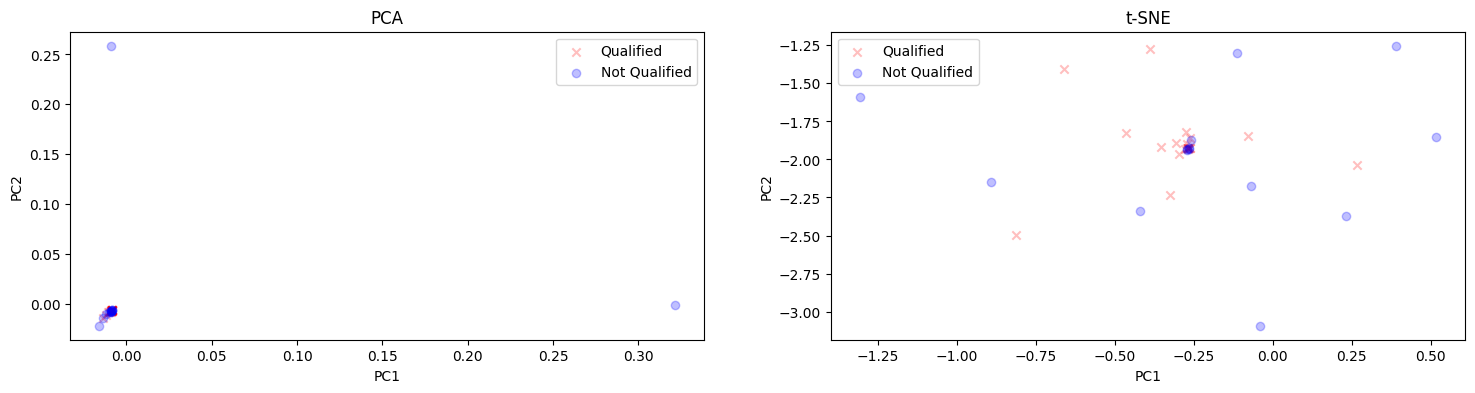

In [27]:

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a PCA and a t-SNE object to reduce the dimensionality to 2
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

# Plot the PCA transformation
reduction_scatter(pca, ax1, 'PCA')

# Plot the t-SNE transformation
reduction_scatter(tsne, ax2, 't-SNE')

# Show the plot
plt.show()

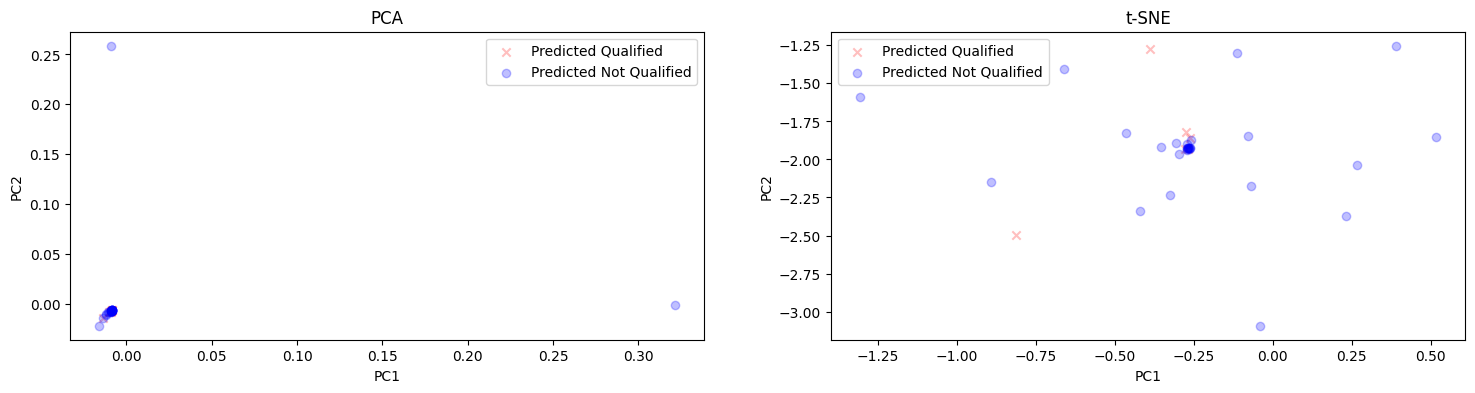

In [28]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

# Plot the PCA transformation
reduction_scatter(pca, ax1, 'PCA', prediction_list, left_label='Predicted Qualified', right_label='Predicted Not Qualified')

# Plot the t-SNE transformation
reduction_scatter(tsne, ax2, 't-SNE', prediction_list, left_label='Predicted Qualified', right_label='Predicted Not Qualified')

# Show the plot
plt.show()

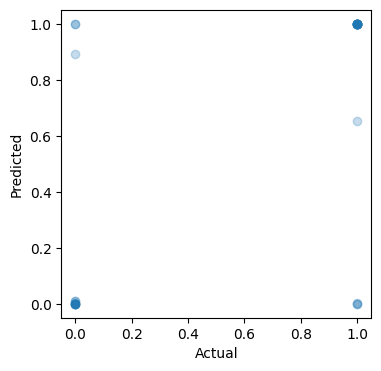

In [31]:

# Create a figure with one subplot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Create a scatter plot of the actual and predicted qualifications
ax.scatter(actual_list, prediction_list, alpha=0.25)

# Add axis labels
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted');

In [35]:

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(actual_list, [int(p) for p in prediction_list])
print(conf_matrix)

[[14  0]
 [15  6]]



<h4 id="avoidable-bias">Avoidable bias</h4>
<p><img src="https://user-images.githubusercontent.com/62474292/101159783-46aed780-3671-11eb-8ed9-748b63598ee9.png" alt="bias_variance"></p>

In [36]:

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(actual_list, [int(p) for p in prediction_list])
error = 1 - accuracy
error_percentage = error * 100
print(error_percentage)

42.85714285714286



<p>Example: Cat vs Non-Cat
<img src="https://user-images.githubusercontent.com/62474292/101159789-47e00480-3671-11eb-8bbb-b7f96ed53144.png" alt="example"></p>

<ul>
  <li>
    <p>Scenario A <br>
There is a 7% gap between the performance of the training set and the human level error. It means that <strong>the algorithm isn’t fitting well with the training set</strong> since the target is around 1%. To resolve the issue, we use <strong>bias reduction technique such as training a bigget neural network or running the training set longer.</strong></p>
  </li>
  <li>
    <p>Scenario B <br>
The training set is doing good since there is only a 0.5% difference with the human level error. The difference between the training set and the human level error is called <strong>avoidable bias</strong>. The focus here is to reduce the variance since the difference between the training error and the development error is 2%. To resolve the issue, we use <strong>variance reduction technique such as regularization or have a bigger training set.</strong></p>
  </li>
</ul>

<h4 id="understanding-human-level-performance">Understanding human-level performance<a class="header-link" href="#understanding-human-level-performance" title="Permalink"><span class="sr-only">Permalink</span><i class="fas fa-link"></i></a></h4>
<p>Human-level error gives an estimate of Bayes error.</p>

<p>Example 1: Medical image classification
<img src="https://user-images.githubusercontent.com/62474292/101161464-29c7d380-3674-11eb-8a83-c92ef428da9a.png" alt="ex1"></p>

<p>The definition of human-level error depends on the purpose of the analysis, in this case, by definition the Bayes error is lower or equal to 0.5%.</p>

<p>Example 2: Error analysis
<img src="https://user-images.githubusercontent.com/62474292/101161469-2a606a00-3674-11eb-909c-8921a0b3c39e.png" alt="ex2"></p>

<ul>
  <li>
    <p>Scenario A <br>
In this case, the choice of human-level performance doesn’t have an impact. The avoidable bias is between 4-4.5% and the variance is 1%. Therefore, <strong>the focus should be on bias reduction technique.</strong></p>
  </li>
  <li>
    <p>Scenario B <br>
In this case, the choice of human-level performance doesn’t have an impact. The avoidable bias is between 0-0.5% and the variance is 4%. Therefore, <strong>the focus should be on variance reduction technique.</strong></p>
  </li>
  <li>
    <p>Scenario C <br>
In this case, the estimate for Bayes error has to be 0.5% since <strong>you can’t go lower than the human-level performance otherwise the training set is overfitting</strong>. Also, the avoidable bias is 0.2% and the variance is 0.1%. Therefore, <strong>the focus should be on bias reduction technique.</strong></p>
  </li>
</ul>

<p><strong>Summary of bias/variance with human-level performance</strong></p>
<ul>
  <li>Human-level error is a proxy for Bayes error</li>
  <li>If the diff(human-level error, training error) &gt; diff(training error, development error), then focus on bias reduction technique</li>
  <li>If the diff(human-level error, training error) &lt; diff(training error, development error), then focus on variance reduction technique</li>
</ul>

<h4 id="surpassing-human-level-performance">Surpassing human-level performance<a class="header-link" href="#surpassing-human-level-performance" title="Permalink"><span class="sr-only">Permalink</span><i class="fas fa-link"></i></a></h4>

<p>Example1: Classification task
<img src="https://user-images.githubusercontent.com/62474292/101162241-69db8600-3675-11eb-8c18-29bbfdb31dc7.png" alt="ex1"></p>

<ul>
  <li>
    <p>Scenario A <br>
In this case, the Bayes error is 0.5%, therefore the avoidable bias is 0.1% and the variance is 0.2%.</p>
  </li>
  <li>
    <p>Scenario B <br>
In this case, there is not enough information to know if bias reduction or variance reduction has to be done on the algorithm. It doesn’t mean that the model cannot be improve, it means that the conventional ways to know if bias reduction or variance reduction are not working in this case. <br><br></p>
  </li>
</ul>

<p>There are many problems where machine learning significantly surpasses human-level performance, especially with structured data</p>
<ul>
  <li>Online advertising</li>
  <li>Product recommendations</li>
  <li>Logistics (predicting transit time)</li>
  <li>Loan approvals</li>
</ul>

<h4 id="improving-your-model-performance">Improving your model performance<a class="header-link" href="#improving-your-model-performance" title="Permalink"><span class="sr-only">Permalink</span><i class="fas fa-link"></i></a></h4>

<p>There are 2 fundamental assumptions of supervised learning. <br>
The first one is to <strong>have a low avoidable bias</strong> which means that the training set fits well. <br>
The second one is to <strong>have a low or acceptable variance</strong> which means that the training set performance generalizes well to the development set and test set.</p>

<p><strong>Summary</strong>
<img src="https://user-images.githubusercontent.com/62474292/101162234-68aa5900-3675-11eb-9926-6226d8f7f7f0.png" alt="summary"></p>

<p>[Source] https://www.coursera.org/learn/machine-learning-projects</p>